# Loading the data

In [3]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import sklearn


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score 
from sklearn.metrics import average_precision_score, recall_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

data_dir='./dataset/'

In [4]:
df = pd.read_csv(data_dir+'df_processed.csv')
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,comment_lower,has_apostrophe,has_new_line,com_processed
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...,1,1,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...,1,0,aww matches background colour seemingly stuck ...


In [5]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LEN = 500 # length of each text
MAX_WORDS   = 1000 # use only this many max used words

def prepare_inputs(df, column, text_to_matrix=False):
    X_train_, X_test, y_train_, y_test = train_test_split(df[column].values,
                                                          df[target_columns].values,
                                                          test_size=0.2)
    
    X_train,  X_val, y_train, y_val = train_test_split(X_train_,
                                                       y_train_,
                                                       test_size=0.25)
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)

    if text_to_matrix:
        X_train = tokenizer.texts_to_matrix(X_train)
        X_val   = tokenizer.texts_to_matrix(X_val)    
        X_test  = tokenizer.texts_to_matrix(X_test)
    else:
        X_train = tokenizer.texts_to_sequences(X_train)
        X_val   = tokenizer.texts_to_sequences(X_val)    
        X_test  = tokenizer.texts_to_sequences(X_test)

        X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')
        X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')
        X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)

(X_train, X_val, X_test, y_train, y_val, y_test, tokenizer) = prepare_inputs(df, "com_processed" )

X_train.shape: (95706, 500) y_train.shape:(95706, 6)
X_test.shape: (31903, 500) y_test.shape:(31903, 6)
X_val.shape: (31902, 500) y_val.shape:(31902, 6)


In [ ]:
def plot_history(history, ax=None):                                                                                                                           
    
    if ax is None:
        (fig, ax) = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(history.history['loss'], label='Training loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].legend()

    ax[1].plot(history.history['binary_accuracy'], label='Training accuracy')
    ax[1].plot(history.history['val_binary_accuracy'], label='validation accuracy')
    ax[1].legend()



## Model: Neural network

In [7]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy

In [22]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')#, metrics='accuracy')
    return model

In [23]:
n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]

In [24]:
model =  get_model(n_inputs, n_outputs)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
Total params: 5,076
Trainable params: 5,076
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5, batch_size=32, verbose=1)

Epoch 1/5
2991/2991 [==============================] - 3s 1ms/step - loss: 0.5456 - val_loss: 0.1854
Epoch 2/5
2991/2991 [==============================] - 3s 916us/step - loss: 0.1626 - val_loss: 0.1494
Epoch 3/5
2991/2991 [==============================] - 3s 937us/step - loss: 0.1461 - val_loss: 0.1418
Epoch 4/5
2991/2991 [==============================] - 3s 932us/step - loss: 0.1422 - val_loss: 0.1398
Epoch 5/5
2991/2991 [==============================] - 3s 963us/step - loss: 0.1407 - val_loss: 0.1391


In [26]:
history.history

{'loss': [0.5455724596977234,
  0.1625794619321823,
  0.1461421698331833,
  0.14218628406524658,
  0.1406852900981903],
 'val_loss': [0.18544940650463104,
  0.14941467344760895,
  0.14179903268814087,
  0.13981595635414124,
  0.13910914957523346]}

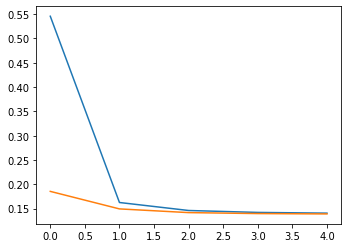

In [27]:
plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.subplot(122)
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])

In [28]:
ypred = model.predict(X_val)
ypred_class = np.round(ypred)
print (ypred_class.sum())

13.0


In [ ]:
ypred = model.predict(Xte)
ypred_class = ypred.round()
acc = accuracy_score(yte, ypred_class)
print('>%.3f' % acc)

In [6]:
y_train[:,0].shape

(95706,)

In [7]:
def model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='relu', use_bias=True))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_accuracy])
    return model

In [8]:
model = model_dense(X_train, y_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 501       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [9]:
#es = EarlyStopping(patience=3)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5, batch_size=32, verbose=1)
                   #callbacks=[es])

Epoch 1/5
2991/2991 [==============================] - 3s 984us/step - loss: 0.4252 - binary_accuracy: 0.9596 - val_loss: 0.1918 - val_binary_accuracy: 0.9627
Epoch 2/5
2991/2991 [==============================] - 3s 907us/step - loss: 0.1612 - binary_accuracy: 0.9634 - val_loss: 0.1487 - val_binary_accuracy: 0.9627
Epoch 3/5
2991/2991 [==============================] - 3s 1ms/step - loss: 0.1433 - binary_accuracy: 0.9634 - val_loss: 0.1434 - val_binary_accuracy: 0.9627
Epoch 4/5
2991/2991 [==============================] - 3s 989us/step - loss: 0.1411 - binary_accuracy: 0.9634 - val_loss: 0.1429 - val_binary_accuracy: 0.9627
Epoch 5/5
2991/2991 [==============================] - 3s 959us/step - loss: 0.1409 - binary_accuracy: 0.9634 - val_loss: 0.1429 - val_binary_accuracy: 0.9627


In [10]:
def plot_history(history, ax=None):                                                                                                                           
    
    if ax is None:
        (fig, ax) = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(history.history['loss'], label='Training loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].legend()

    ax[1].plot(history.history['binary_accuracy'], label='Training accuracy')
    ax[1].plot(history.history['val_binary_accuracy'], label='validation accuracy')
    ax[1].legend()



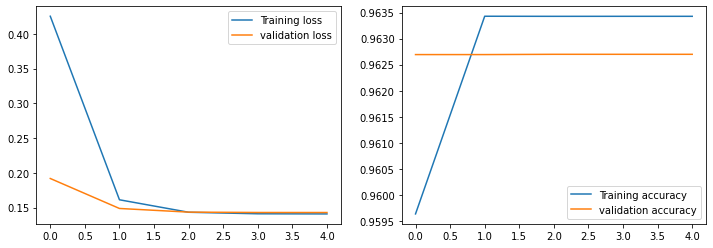

In [11]:
plot_history(history)

In [12]:
y_prob = model.predict(X_val)
y_prob.shape

(31902, 6)

In [21]:
#y_val[y_val.sum(axis=1)>2]
y_val[3:7]

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
y_prob[3:7]

array([[0.09566575, 0.01029539, 0.05232048, 0.00345063, 0.04886669,
        0.00899345],
       [0.09566575, 0.01029539, 0.05232048, 0.00345063, 0.04886669,
        0.00899345],
       [0.09566575, 0.01029539, 0.05232048, 0.00345063, 0.04886669,
        0.00899345],
       [0.09566575, 0.01029539, 0.05232048, 0.00345063, 0.04886669,
        0.00899345]], dtype=float32)

In [101]:
y_prob.sum(axis=1)

array([0.29830348, 0.23411909, 0.30193272, ..., 0.3006101 , 0.30193272,
       0.18140325], dtype=float32)

In [102]:
for i in range(31902):
    sm = (np.sum([round(v) for v in y_prob[i]]))#[i].sum())
    if sm >0:
        print (i, sm)
    #if y_prob[i].sum()>.5:
    #    print (y_prob[i])
    #if y_val[i].sum()>0:
    #    print ("actual label: ", y_val[i], "predicted", [round(v, 2) for v in y_prob[i]])

In [46]:
y_prob[:10]

array([[0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993],
       [0.09459469, 0.0100345 , 0.05250493, 0.00325999, 0.04845721,
        0.00874993]], dtype=float32)

In [43]:
#y_val[
#np.where(np.sum(y_val, axis=1) >0 , 1, 0) 
y_val[np.sum(y_val[0:100, :], axis=1) >0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 31902 but corresponding boolean dimension is 100

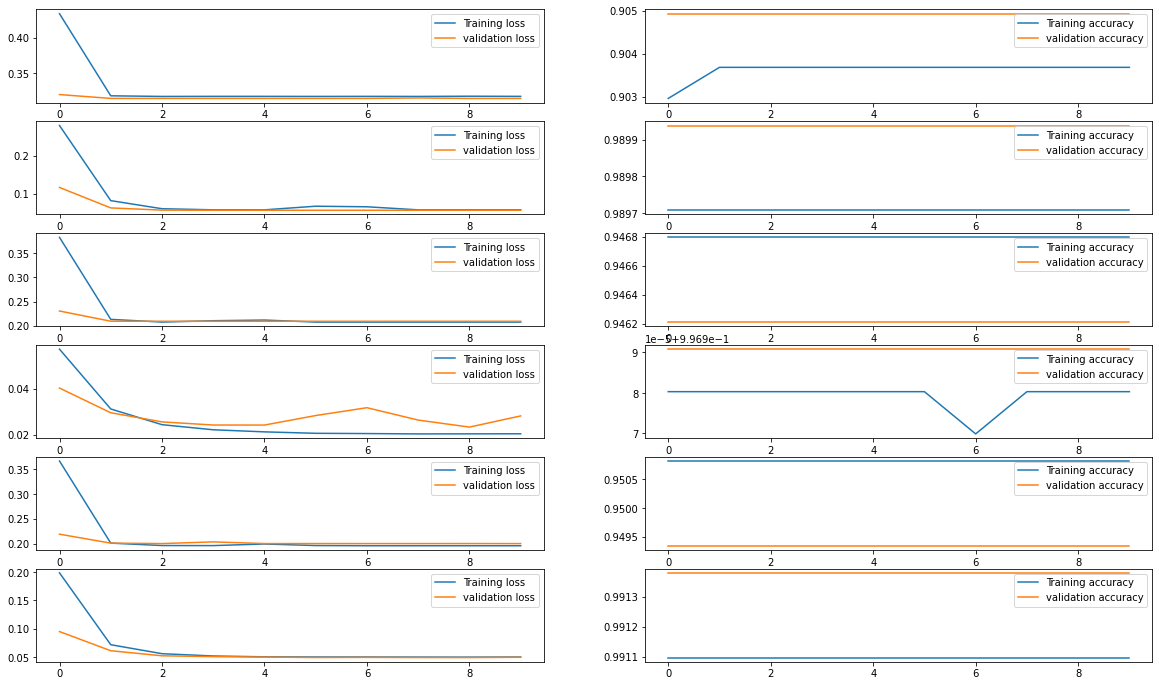

In [47]:
def acc_plots_():
    #all_models = train_all_features()
    fig, ax=plt.subplots(6,2, figsize=(20,12))
    for i, (feature, model, history) in enumerate(all_models):
        ax[i,0].plot(history.history['loss'], label='Training loss')
        ax[i,0].plot(history.history['val_loss'], label='validation loss')        
        #ax[i,0].set_grid()
        ax[i,0].legend()

        ax[i,1].plot(history.history['accuracy'], label='Training accuracy')
        ax[i,1].plot(history.history['val_accuracy'], label='validation accuracy')
        #ax[i,1].set_grid()
        ax[i,1].legend()
        
acc_plots_()

In [7]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='relu'))#, kernel_regularizer='l2'))
    #model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def make_model_lstm(X_train, y_train, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=2000))#input_length=X_train.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 501       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/10
2991/2991 [==============================] - 3s 994us/step - loss: 1.9641 - accuracy: 0.6305 - val_loss: 1.2794 - val_accuracy: 0.7228
Epoch 2/10
2991/2991 [==============================] - 3s 953us/step - loss: 0.8990 - accuracy: 0.7847 - val_loss: 0.6678 - val_accuracy: 0.8320
Epoch 3/10
2991/2991 [==============================] - 3s 1ms/step - loss: 0.5446 - accuracy: 0.8721 - val_loss: 0.4665 - val_accuracy: 0.8985
Epoch 4/10
2991/2991 [==============================] - 3s 996us/step - loss: 0.4265 - accuracy: 0.9227 - val_loss: 0.4021 - val_accuracy: 0.9385
Epoch 5/10
2991/2991 [==============================] - 3s 902us/step - loss: 0.3957 - accuracy: 0.9667 - val_loss: 0.3927 - val_accuracy: 0.9939
Epoch 6/10
2991/2991 [==============================] - 3s 957us/step - loss: 0.3928 - accuracy: 0.9938 - val_loss: 0.3924 - val_accuracy: 0.9940
Epoch 7/10
2991/2991 [==============================] - 4s 1ms/step - loss: 0.3920 - accuracy: 0.9939 - val_loss: 0.3921 - val

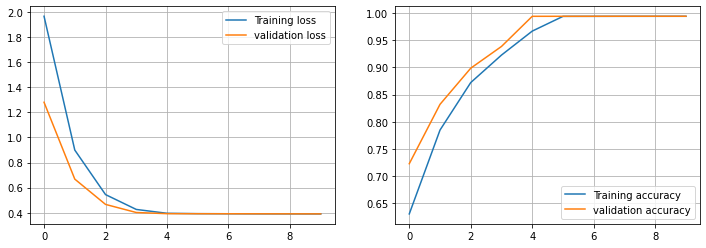

In [8]:
model1= make_model_dense(X_train, y_train)
display(model1.summary())
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=10, batch_size=32, verbose=1)
from helper import plot_history
plot_history(history1)

## Findings

- so far a single dense layer 2 nodes with Adam(learning_rate=0.00001) worked nice with .9946 accuracy on val set.

```
model = Sequential()
model.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu',                 kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
return model
```

### NOTE:
- I first started with 2 Dense layers and 128 nodes each. That had a serious overfitting problem. The accuracy fluctuated from .99 -> .30 -> .87 -> .42 -> .95.
- Reduced the layer size to 1 the fluctuation was still there but it was less severe.
- Then reduced the node size to smaller number and eventually 1 and it was a great convergence only in 3 iteration.
- Learning rate and kernel_regularizer didn't have much effect once I reduced the # of nodes to < 10.



In [22]:
def get_tpr(actual, pred):
    tp = np.sum((actual==1) & (pred == 1)) 
    fn = np.sum((actual==1) & (pred == 0)) 
    return tp/(tp+fn)

def get_fpr(actual, pred):
    fp = np.sum((actual == 0) & (pred == 1)) 
    tn = np.sum((actual == 0) & (pred == 0)) 
    return fp/(fp+tn)

def get_acc(actual, pred):
    return np.sum(actual==pred)/len(actual)


In [14]:
from tensorflow.python.keras.utils import np_utils

In [19]:
y_proba=model1.predict(X_val)

In [29]:
y_val

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [20]:
y_proba

array([[0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107],
       [0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107],
       [0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107],
       ...,
       [0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107],
       [0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107],
       [0.17633718, 0.1632757 , 0.16632573, 0.16303392, 0.16778642,
        0.16324107]], dtype=float32)

In [28]:
for th in [0.158, 0.159, 0.16, 0.161, 0.162]:
    ypred = (model1.predict(X_val)>th).astype('int')
    
    tpr = get_tpr(y_val, ypred)
    fpr = get_tpr(y_val, ypred)
    acc = get_tpr(y_val, ypred)
    
    conf_matrix = multilabel_confusion_matrix(ypred, y_val)
    
    print (conf_matrix)
    print (th, tpr, fpr, acc, conf_matrix[0,1], conf_matrix[1,0] )

    
    #
    #fig, ax = plt.subplots(1,6, figsize=(20,3))
    #for i in range(6):
    #    sns.heatmap(conf_matrix[i], ax=ax[i], annot=True, cbar=False, cmap="viridis")
    #plt.show()

[[[    3     0]
  [28866  3033]]

 [[    3     0]
  [31578   321]]

 [[    2     0]
  [30184  1716]]

 [[    3     0]
  [31803    96]]

 [[    0     0]
  [30286  1616]]

 [[    3     0]
  [31624   275]]]
0.158 1.0 1.0 1.0 [28866  3033] [3 0]
[[[    3     0]
  [28866  3033]]

 [[    3     0]
  [31578   321]]

 [[    2     0]
  [30184  1716]]

 [[    3     0]
  [31803    96]]

 [[    0     0]
  [30286  1616]]

 [[    3     0]
  [31624   275]]]
0.159 1.0 1.0 1.0 [28866  3033] [3 0]
[[[    3     0]
  [28866  3033]]

 [[    3     0]
  [31578   321]]

 [[    2     0]
  [30184  1716]]

 [[    3     0]
  [31803    96]]

 [[    0     0]
  [30286  1616]]

 [[    3     0]
  [31624   275]]]
0.16 1.0 1.0 1.0 [28866  3033] [3 0]
[[[    3     0]
  [28866  3033]]

 [[    3     0]
  [31578   321]]

 [[    2     0]
  [30184  1716]]

 [[    3     0]
  [31803    96]]

 [[    0     0]
  [30286  1616]]

 [[    3     0]
  [31624   275]]]
0.161 1.0 1.0 1.0 [28866  3033] [3 0]
[[[    3     0]
  [28866  3033]]


In [25]:
multilabel_confusion_matrix(pred_labels, y_val)

array([[[   10,     0],
        [28840,  3052]],

       [[   13,     0],
        [31583,   306]],

       [[    2,     0],
        [30197,  1703]],

       [[   13,     0],
        [31779,   110]],

       [[    0,     0],
        [30329,  1573]],

       [[   13,     0],
        [31592,   297]]])

In [9]:
actual = np.array( [[1,1,0,1,0,0], [0,0,0,1,1,1], [0,1,0,1,0,0]] )
pred   = np.array( [[1,0,0,0,0,0], [1,0,1,1,1,1], [0,1,0,1,0,0]] )

for n in range(6):
    #tpr_ = tpr(actual[n,:], pred[n,:])
    tpr_ = tpr(actual[:,n], pred[:,n])
    print (tpr_)

1.0
0.5
nan
0.6666666666666666
1.0
1.0


<ipython-input-8-4fb46de70b4b>:4: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)


In [10]:
ypred = model1.predict(X_val)
[roc_auc_score(y_val[:,n], ypred[:,n]) for j in range(6)]
#[roc_auc_score(targets[:,j],p[:,j]) for j in range(6)]

NameError: name 'roc_auc_score' is not defined

In [ ]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score 
from sklearn.metrics import average_precision_score, recall_score, classification_report



In [ ]:
#classification_report(model1.predict(X_val), y_val)

In [ ]:
(model1.predict(X_val)>0.16).astype('int').shape

In [ ]:
ypred = (model1.predict(X_val)>0.17).astype('int')

In [ ]:
for th in [0.163]:
    ypred = (model1.predict(X_val)>th).astype('int')   
    for n in range(6):
        tpr_ = tpr(y_val[:,n], ypred[:,n])
        print (tpr_)

In [ ]:
np.sum(y_val)

In [ ]:
from helper import calc_prediction

In [ ]:
model1.predict_step(X_val)[0]

In [ ]:
model1.predict_proba(X_val)[0]

In [ ]:
model1.predict(X_val)

In [ ]:
y_pred = model1.predict(X_val)

In [ ]:
(model1.predict(X_val) > 0.1).astype("int")

In [ ]:
y_pred = model1.predict(X_val)
#report = classification_report(y_test, y_pred)
#confusionmatrix=confusion_matrix( y_test, y_pred)



In [ ]:
def accuracy_multiclass(actual, predicted):
    nclasses = np.shape(actual)[1]
    for n in range(nclasses):
        act = actual[:,n]
        pred = predicted[:,n]
        #print (act, pred)
        tpr = sum(act==pred)
        tpr = sum(act==pred)

        print (n, tpr)
        
    
actual = np.array( [[1,1,0,1,0,0], [0,0,0,1,1,1], [0,1,0,1,0,0]] )
pred   = np.array( [[1,0,0,0,0,0], [1,0,1,1,1,1], [0,1,0,1,0,0]] )

accuracy_multiclass(actual, pred)

In [ ]:
actual = np.array( [[1,1,0,1,0,0], [0,0,0,1,1,1], [0,1,0,1,0,0]] )
pred   = np.array( [[1,0,0,0,0,0], [1,0,1,1,1,1], [0,1,0,1,0,0]] )

report = classification_report(actual, pred)

In [ ]:
tmp=y_pred[:3]
print (tmp)
th=0.15
(tmp>=th).astype(int)

In [ ]:
np.sum(y_pred, axis=1).sum()

In [ ]:
print (Donot run the following cells)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score

In [ ]:
def print_evaluation_scores(y_val, predicted):
    acc        = 100*accuracy_score(y_val, predicted)
    f1_micro   = 100*f1_score(y_val, predicted, average='micro')
    avg_prec_micro = 100*average_precision_score(y_val, predicted, average='micro')
    roc_auc    = 100*roc_auc_score(y_val, predicted)
    
    print ("Accuracy \t= %1.2f \nF1_micro\t= %1.2f" %(acc, f1_micro))
    print ("Avg Prec micro\t= %1.2f \nROC_AUC score\t= %1.2f" % ( avg_prec_micro, roc_auc))

In [ ]:
print ("Logistic Regression with TFIDF features")
print_evaluation_scores(y_test_tf, y_pred_labs)

In [23]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold

# get the dataset
def get_dataset():
        X, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=3, n_labels=2, random_state=1)
        return X, y

# get the model
def get_model(n_inputs, n_outputs):
        model = Sequential()
        model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
        model.add(Dense(n_outputs, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model


In [27]:
X, y = get_dataset()
print (X[:3], y[:3])

[[ 3.  3.  6.  7.  8.  2. 11. 11.  1.  3.]
 [ 7.  6.  4.  4.  6.  8.  3.  4.  6.  4.]
 [ 5.  5. 13.  7.  6.  3.  6. 11.  4.  2.]] [[1 1 0]
 [0 0 0]
 [1 1 0]]


In [29]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

In [30]:
n_inputs, n_outputs = Xtr.shape[1], ytr.shape[1]
model = get_model(n_inputs, n_outputs)

In [44]:
#history=model.fit(Xtr, ytr, verbose=0, epochs=50);

history = model.fit(Xtr, ytr,
                    validation_data=(Xte, yte),
                    epochs=50, verbose=0)

In [45]:
yte[:5]

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 0],
       [1, 0, 0]])

In [46]:
ypred = model.predict(Xte)
print (ypred[:5])

[[9.3143612e-01 9.9992073e-01 3.5730898e-01]
 [9.8931819e-01 9.9523628e-01 9.8469877e-01]
 [7.8207397e-01 9.9884772e-01 4.1708380e-02]
 [9.9999714e-01 8.3423924e-01 7.9198253e-06]
 [9.9553323e-01 1.5491813e-02 1.9741952e-05]]


In [ ]:
ypred = model.predict(Xte)
ypred_class = ypred.round()
acc = accuracy_score(yte, ypred_class)
print('>%.3f' % acc)

KeyError: 'binary_accuracy'

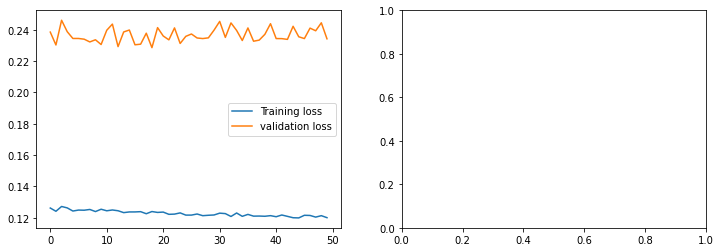

In [42]:
plot_history(history)

In [39]:
history.history['loss']

[0.1488972157239914,
 0.14877134561538696,
 0.1489759087562561,
 0.14759211242198944,
 0.14710357785224915,
 0.14705859124660492,
 0.14629299938678741,
 0.14594396948814392,
 0.14785131812095642,
 0.14705193042755127,
 0.14541059732437134,
 0.14525510370731354,
 0.14582592248916626,
 0.1462102085351944,
 0.1453489512205124,
 0.14435915648937225,
 0.14411243796348572,
 0.14368803799152374,
 0.14354513585567474,
 0.14303746819496155,
 0.14272145926952362,
 0.14274927973747253,
 0.14310027658939362,
 0.14290007948875427,
 0.14123497903347015,
 0.1423179656267166,
 0.1421816349029541,
 0.1405041217803955,
 0.1399458795785904,
 0.141187846660614,
 0.1422709971666336,
 0.1409921795129776,
 0.13910633325576782,
 0.1397201269865036,
 0.13970215618610382,
 0.1413741409778595,
 0.13886739313602448,
 0.14036430418491364,
 0.1377258449792862,
 0.13837049901485443,
 0.13754326105117798,
 0.13722939789295197,
 0.13766415417194366,
 0.1361919790506363,
 0.13636742532253265,
 0.13609975576400757,
 0.1

In [ ]:
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction on the test set
yhat = model.predict(X_test)
# round probabilities to class labels
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
# store result
print('>%.3f' % acc)

In [24]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
        results = list()
        n_inputs, n_outputs = X.shape[1], y.shape[1]
        # define evaluation procedure
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        # enumerate folds
        for train_ix, test_ix in cv.split(X):
                # prepare data
                X_train, X_test = X[train_ix], X[test_ix]
                y_train, y_test = y[train_ix], y[test_ix]
                # define model
                model = get_model(n_inputs, n_outputs)
                # fit model
                model.fit(X_train, y_train, verbose=0, epochs=100)
                # make a prediction on the test set
                yhat = model.predict(X_test)
                # round probabilities to class labels
                yhat = yhat.round()
                # calculate accuracy
                acc = accuracy_score(y_test, yhat)
                # store result
                print('>%.3f' % acc)
                results.append(acc)
        return results



In [25]:
X, y = get_dataset()
print (X[:3], y[:3])

[[ 3.  3.  6.  7.  8.  2. 11. 11.  1.  3.]
 [ 7.  6.  4.  4.  6.  8.  3.  4.  6.  4.]
 [ 5.  5. 13.  7.  6.  3.  6. 11.  4.  2.]] [[1 1 0]
 [0 0 0]
 [1 1 0]]


In [26]:
# evaluate model
results = evaluate_model(X, y)

>0.840
>0.830
>0.880
>0.850
>0.860
>0.780
>0.770
>0.800
>0.780
>0.760
>0.820
>0.790
>0.780
>0.750
>0.790
>0.800
>0.810
>0.890
>0.810
>0.850
>0.820
>0.850
>0.720
>0.820
>0.840
>0.780
>0.810
>0.790
>0.770
>0.840


In [ ]:

# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))
